In [2]:
pip install keras_metrics

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# importing all necessary libraries to run the code
import re,string
import numpy as np
import pandas as pd
import keras_metrics
import tensorflow.keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding,GlobalMaxPooling1D
# using the variable sw to hold all stopwords that are in English
sw = stopwords.words('english')

Using TensorFlow backend.


In [0]:
#dependencies 
import requests, zipfile, io, os
from gensim.models.fasttext import FastText

#download model
ft_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip'
zpath = 'crawl-300d-2M.vec.zip'
mpath = 'crawl-300d-2M-subword.bin'

if os.path.isfile(zpath):
    #attempt load
    mod = FastText.load_fasttext_format(mpath,encoding='utf-8')
    
elif not os.path.isfile(zpath):
    r = requests.get(ft_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
else:
    z = zipfile.ZipFile(zpath)
    z.extractall()
    mod = FastText.load_fasttext_format(mpath,encoding='utf-8')
   

In [8]:
from tqdm import tqdm
import os, re, csv, math, codecs
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

306it [00:00, 3059.43it/s]

loading word embeddings...


1999996it [02:38, 12591.14it/s]

found 1999996 word vectors


In [0]:
link = 'https://drive.google.com/open?id=0Bz8a_Dbh9Qhbd2JNdDBsQUdocVU' # The shareable link

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

0Bz8a_Dbh9Qhbd2JNdDBsQUdocVU


In [0]:
import gzip
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv') 
with open('Filename.csv', 'rb') as fd:
  gzip_fd = gzip.GzipFile(fileobj=fd)
  data = pd.read_csv(gzip_fd, nrows=1400000) 
#df3 = pd.read_csv('Filename.csv')# Dataset is now stored in a Pandas Dataframe

In [14]:
data.columns=['Target','Headline','HeadlineDetail','HeadlineBody']
data.head(2)

,Target,Headline,HeadlineDetail,HeadlineBody
0,6.0,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
1,3.0,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...


In [0]:
data['text']= data['Headline']+ ' '+data['HeadlineBody']+ ' '+data['HeadlineDetail']

In [16]:
data=data.dropna()
data.head(2)

,Target,Headline,HeadlineDetail,HeadlineBody,text
0,6.0,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What is the best off-road motorcycle trail ? i...
1,3.0,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,What is Trans Fat? How to reduce that? Trans f...


In [17]:
data.isnull().sum()

Target            0
Headline          0
HeadlineDetail    0
HeadlineBody      0
text              0
dtype: int64

In [18]:
#applying pre-processing steps to remove stopwords and words of size less than 2
data['text'] = data['text'].apply(lambda x: x.split())
wordsEng = stopwords.words('english')
data['text'] = data['text'].apply(lambda x:[item for item in x if item not in wordsEng])
data['text'] = data['text'].apply(lambda x: [w for w in x if len(w)>2])
data['text'] = data['text'].apply(lambda x: " ".join(x))
data.head(2)

,Target,Headline,HeadlineDetail,HeadlineBody,text
0,6.0,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What best off-road motorcycle trail hear mojav...
1,3.0,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,What Trans Fat? How reduce that? Trans fats oc...


In [0]:
data.reset_index(inplace=True)

In [0]:
#removing airline company names as pre-processing
testList=[]
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


for t in range(len(data)):
    testList.append(strip_all_entities(strip_links(data['text'][t])))

In [21]:
#converting testList[] list into dataframe for further processing
dat = pd.DataFrame(np.array(testList))
dat.head(2)

,0
0,What best off road motorcycle trail hear mojav...
1,What Trans Fat How reduce that Trans fats occu...


In [0]:
# applying pre-processing to remove special symbols, numbers and converting into lower case
sw = stopwords.words('english')
twitterSentiment=[]
for i in range(len(dat)):
    review = re.sub('[^a-zA-Z]', ' ',dat[0][i])
    review = re.sub('[/(){}\[\]\|@!,;]', ' ',dat[0][i])
    review = re.sub('[^0-9a-zA-Z #+_♥️]', ' ',dat[0][i])#Remove bad symbols
    
    review = re.sub(r'\d+', '',review)
    review = review.lower()
    review = review.split()

    review = [token for token in review if token not in sw]
    review=' '.join(review)
    review=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",review).split())
    twitterSentiment.append(review)

In [23]:
#converting twitterSentiment[] list into dataframe for serving it to keras tokenizer
dataSetFinal = pd.DataFrame(np.array(twitterSentiment))
dataSetFinal.head(5)

,0
0,best road motorcycle trail hear mojave road am...
1,trans fat reduce trans fats occur manufactured...
2,many planes fedex according www fedex com web ...
3,san francisco bay area make sense rent buy ren...
4,best way clean keyboard commercial kits availa...


In [0]:
MAX_NB_WORDS = 100000
embed_dim = 300 
max_seq_len =752
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [25]:
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words=7500, lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(dataSetFinal[0].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(dataSetFinal[0].values)
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  553119


In [26]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 14778


In [31]:
from keras import regularizers
from keras import optimizers
from keras import backend as K
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(10, activation='softmax'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy','mae',keras_metrics.precision(), keras_metrics.recall()])
model.summary()

training CNN ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 752, 300)          30000000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 752, 64)           134464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 376, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 376, 64)           28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [33]:
#batch_size=64
Y = pd.get_dummies(data['Target']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.30)
#Here we train the Network.

#model training
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
hist


Train on 474801 samples, validate on 52756 samples
Epoch 1/8
 - 64s - loss: 0.1698 - acc: 0.9412 - mean_absolute_error: 0.0936 - precision: 0.7886 - recall: 0.3925 - val_loss: 0.1457 - val_acc: 0.9485 - val_mean_absolute_error: 0.0817 - val_precision: 0.8128 - val_recall: 0.4553
Epoch 2/8
 - 59s - loss: 0.1508 - acc: 0.9475 - mean_absolute_error: 0.0834 - precision: 0.7981 - recall: 0.4429 - val_loss: 0.1398 - val_acc: 0.9502 - val_mean_absolute_error: 0.0794 - val_precision: 0.7763 - val_recall: 0.4978
Epoch 3/8
 - 59s - loss: 0.1449 - acc: 0.9492 - mean_absolute_error: 0.0803 - precision: 0.7984 - recall: 0.4597 - val_loss: 0.1383 - val_acc: 0.9506 - val_mean_absolute_error: 0.0756 - val_precision: 0.7574 - val_recall: 0.5287
Epoch 4/8
 - 63s - loss: 0.1411 - acc: 0.9505 - mean_absolute_error: 0.0782 - precision: 0.7989 - recall: 0.4745 - val_loss: 0.1381 - val_acc: 0.9505 - val_mean_absolute_error: 0.0760 - val_precision: 0.8003 - val_recall: 0.4795
Epoch 5/8
 - 62s - loss: 0.1383 

In [34]:
score=[]
score=model.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
#keras.metrics.binary_accuracy(Y_valid,pred)
print("score: %.2f" %(score[0]))
print("validation accuracy: %.2f" % (score[1]))
print("recall: %.2f" %(score[4]))
print("Precision: %.2f" % (score[3]))

score: 0.14
validation accuracy: 0.95
recall: 0.53
Precision: 0.76


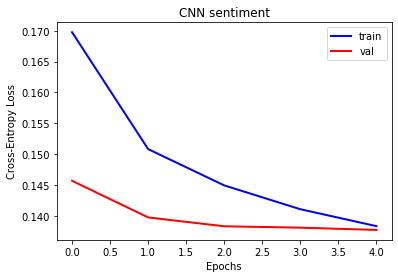

In [36]:
#generate plots
from google.colab import files
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.savefig('training & validation LossYAhooQAFT.pdf')
files.download('training & validation LossYAhooQAFT.pdf') 
plt.show()

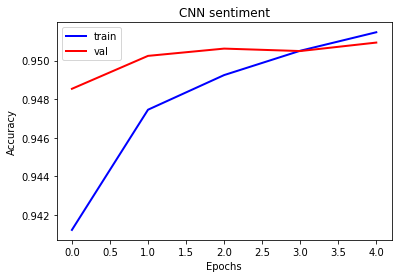

In [38]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('training & validation accuracyYAhooQAFT.pdf')
files.download('training & validation accuracyYAhooQAFT.pdf')
plt.show()